Idea code name: `S3P10`

In [1]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, Flatten, MaxPooling2D, LSTM, Reshape
from keras.models import model_from_json, Model
import keras.backend as K
import keras.layers as KL
import keras

# from s1p10_training_utils import gen_classifier_dataset_lstm_rev

from s1p10_training_utils import one_hot_encode, find_angle_id

import json
import time

import numpy as np
import sklearn
import pandas as pd
from scipy.stats import bernoulli
from tqdm import tqdm
import cv2 as cv
import os

Using TensorFlow backend.


# Global Config

In [2]:
IMAGE_SHAPE = (200, 200, 1)

NUM_SEE = 3
NUM_PRED = 5

BINS_EDGE = np.load("./s1p10_data/s1p10_bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

with open('./s1p10_data/s1p10_classes_weight.json', 'r') as fp:
    CLASSES_WEIGHT = json.load(fp)
    
NUM_LSTM = 128

In [3]:
def gen_classifier_dataset_lstm_rev(df_path, 
                                    num_classes,
                                    num_see,
                                    num_predicts, 
                                    bins_edge, 
                                    image_shape, 
                                    num_samples=None,
                                    data_root_dir=None, flip_prob=0.5):
    """
    Generate dataset as list of numpy array from dataframe
    
    Input:
        df (pandas.DataFrame)
        num_labels (int)
        image_shape (tuple)
       
    Output:
        X (numpy.ndarray): model has 1 input
        y (list) of numpy.ndarray (y is a list because model has multiple outputs)
    
    """
    df = pd.read_csv(df_path)
    
    if not num_samples:
        num_samples = len(df)
    
    X = [np.zeros((num_samples, ) + image_shape) for i in range(num_see)] # list of input 
    
    # Note: j is used to iterate output list
    y = [np.zeros((num_samples, num_classes)) for j in range(num_predicts)]
    
    flip = bernoulli.rvs(flip_prob, size=num_samples) == 1
    
    
    def process_img(img_path, image_shape, is_flip):
        img = cv.imread(img_path, 0)
        bottom_half = img[100 : , :]
        # down sample & reshape image
        img = np.float32(cv.resize(bottom_half, (image_shape[1], image_shape[0]), interpolation=cv.INTER_AREA))
        if len(img.shape) == 2:
            img = img.reshape((image_shape))
        # check if this sample needs to be flipped
        if is_flip:
            img = np.fliplr(img)
        return img
    
    # Iterate through the whole dataset
    for i in tqdm(range(num_samples)):  # i is used to iterate batch 
        frame_name_list = df.iloc[i].frame_name[1: -1].split(", ")
        # get image & store image to X
        for j in range(num_see):
            img_path = os.path.join(data_root_dir, frame_name_list[j][1: -1])
            X[j][i, :, :, :] = process_img(img_path, image_shape, flip[i])
        
        # create y
        angle_val_list = df.iloc[i].angle_val[1: -1].split(", ")
        
        for j in range(num_see, num_see + num_predicts):
            angle_val = angle_val_list[j]
            if flip[i]:
                angle_id = find_angle_id(-float(angle_val), bins_edge)
            else:
                angle_id = find_angle_id(float(angle_val), bins_edge)
            # one hot encode
            y[j - num_see][i, :] = one_hot_encode(angle_id, num_classes)

    return X, y

In [5]:
gen_param = {'num_classes': NUM_CLASSES, 
             'num_see': NUM_SEE,
             'num_predicts': NUM_PRED,
             'bins_edge': BINS_EDGE, 
             'image_shape': IMAGE_SHAPE, 
             'num_samples': None, 
             'data_root_dir': "/home/user/Bureau/Dataset/udacity/", 
             'flip_prob': 0.5}

X_train, y_train = gen_classifier_dataset_lstm_rev("./s1p10_data/lstm_rev_CH2_002_output_training.csv",
                                                   **gen_param)


In [6]:
X_train_2 = []
target_shape_train = (y_train[0].shape[0], 1, y_train[0].shape[1])
for i in range(NUM_PRED):
    if i == 0:
        X_train_2.append(np.zeros(target_shape_train))
    else:
        X_train_2.append(np.reshape(y_train[i - 1], target_shape_train))
a_0_train = np.zeros((y_train[0].shape[0], NUM_LSTM))
c_0_train = np.zeros((y_train[0].shape[0], NUM_LSTM))

In [7]:
X_val, y_val = gen_classifier_dataset_lstm_rev("./s1p10_data/lstm_rev_CH2_002_output_validation.csv", 
                                               **gen_param)
X_val_2 = []
target_shape = (y_val[0].shape[0], 1, y_val[0].shape[1])
for i in range(NUM_PRED):
    if i == 0:
        X_val_2.append(np.zeros(target_shape))
    else:
        X_val_2.append(np.reshape(y_val[i - 1], target_shape))
a_0_val = np.zeros((y_val[0].shape[0], NUM_LSTM))
c_0_val = np.zeros((y_val[0].shape[0], NUM_LSTM))

In [8]:
X_val_2[0].shape

(2020, 1, 114)

# 1. Model Acrchitect

In [9]:
def convolutional_block(X, num_filters, shape_filters, strides, stage):
    """
    Implementation of convolutional block in Residual network
    
    Input:
        X (tensor): input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        num_filters (list of 3 ints): list of number of filters
        shape_filters (list of 3 ints): list of filters' shape
        strides (list of 3 ints): list of strides
        stage (int): stage of this convolutional block in the whole ResNet
        
    Output:
        tensor of shape (m, n_H, n_W, n_C)
    """
    
    # retrieve filters shape from filters
    n1, n2, n3 = num_filters
    f1, f2, f3 = shape_filters
    
    # retrieve strides from strides
    s1, s2, s3 = strides
    
    # create name
    bn_name_base = 'bn_' + str(stage) + '_'
    conv_name_base = 'conv_' + str(stage) + '_'
    
    # save value of X
    X_shorcut = X
    
    # First component of the main path
    X = BatchNormalization(name=bn_name_base + 'a')(X)
    X = Activation('relu', name="feature_map_%d" % (stage - 1))(X)
    X = Conv2D(n1, (f1, f1), strides=[s1, s1], padding='same',
               name=conv_name_base + 'a')(X)
    
    # Second component of the main path
    X = BatchNormalization(name=bn_name_base + 'b')(X)
    X = Activation('relu')(X)
    X = Conv2D(n2, (f2, f2), strides=[s2, s2], padding='same',
               name=conv_name_base + 'b')(X)
    
    # Short-cut
    X_shorcut = Conv2D(n3, (f3, f3), strides=[s3, s3], padding='same', 
                       name=conv_name_base + 'c')(X_shorcut)
    
    X = KL.merge.add([X, X_shorcut])
    
    return X

In [10]:
def resnet_body(X_in, branch):
    # Apply 1st convolution & max pooling on input
    X = Conv2D(8, (5, 5), strides=[2,2], padding='same', name='conv_branch_%d'%branch)(X_in)
    X = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(X) 
    
    # First convolutional block
    X = convolutional_block(X, [8, 8, 8], [3, 3, 1], [2, 1, 2], stage=1+branch)
    
    # Second convolutional block
    X = convolutional_block(X, [16, 16, 16], [3, 3, 1], [2, 1, 2], stage=2+branch)
    
    # Third convolutional block
    X = convolutional_block(X, [32, 32, 32], [3, 3, 1], [2, 1, 2], stage=3+branch)
    
    # Output layer of resnet-8
#     X = Flatten()(X)
    X = Activation('relu')(X)
    X = Reshape((1, -1))(X)
    return X

## 1.4 Create Model

In [11]:
def full_model(input_shape, num_lstm):
    """
    Define encoder architecture as ResNet8
    
    Input:
        input_shape (list of ints): shape of input image [n_H, n_W, n_C]
        
    Output:
        model: a Model instance
    """
    
    # Input
    X_in = [Input(shape=input_shape) for i in range(NUM_SEE)]  # to resnet-body
    X_in_2 = [Input(shape=(1, NUM_CLASSES)) for j in range(NUM_PRED)]  # to 2nd LSTM for sampling angle
    
    a_0 = Input(shape=(num_lstm, ), name="a_0")
    c_0 = Input(shape=(num_lstm, ), name="c_0")
    
    # Feature map
    X_feat = [resnet_body(X, 3*j) for j, X in enumerate(X_in)]
    
    LSTM_1 = LSTM(num_lstm, return_state=True)
    LSTM_2 = LSTM(num_lstm, return_state=True)
    
    a = a_0
    c = c_0
    for X in X_feat:
        a, _, c = LSTM_1(X, initial_state=[a, c])
    
    y = []
    for X_2 in X_in_2:
        a, _, c = LSTM_2(X_2, initial_state=[a, c])
        y_hat = Dense(NUM_CLASSES, activation="softmax")(a)
        y.append(y_hat)
    
    model = Model(inputs=X_in + X_in_2 + [a_0, c_0], outputs=y)    
    return model

In [12]:
model = full_model(IMAGE_SHAPE, 128)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv_branch_0 (Conv2D)          (None, 100, 100, 8)  208         input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLaye

In [13]:
model.compile(optimizer='Adam', 
              loss="categorical_crossentropy", 
              loss_weights=[3., 1., 1., 1., 1.], 
              metrics=['acc'])

# Training

In [14]:
batch_size = 50

time_str = time.strftime("%Y_%m_%d_%H_%M")
log_dir = './s1p10_logs/' + time_str

tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir,  
                                          batch_size=batch_size,
                                          write_graph=False,
                                          update_freq='epoch')

early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=3,
                                              restore_best_weights=True)


history = model.fit(x=X_train + X_train_2 + [a_0_train, c_0_train],
                  y=y_train,
                  epochs=45,
                  validation_data=(X_val + X_val_2 + [a_0_val, c_0_val], y_val),
                  class_weight=CLASSES_WEIGHT,
                  initial_epoch=0,
                  shuffle=True,
                  batch_size=batch_size,
                  callbacks=[tb_callback])


Instructions for updating:
Use tf.cast instead.
Train on 18180 samples, validate on 2020 samples
Epoch 1/45
18180/18180 [==============================] - 69s 4ms/step - loss: 18.8712 - dense_1_loss: 3.0189 - dense_2_loss: 2.6861 - dense_3_loss: 2.4460 - dense_4_loss: 2.3471 - dense_5_loss: 2.3354 - dense_1_acc: 0.2311 - dense_2_acc: 0.3318 - dense_3_acc: 0.3993 - dense_4_acc: 0.4047 - dense_5_acc: 0.3997 - val_loss: 15.1681 - val_dense_1_loss: 2.8531 - val_dense_2_loss: 1.9166 - val_dense_3_loss: 1.5920 - val_dense_4_loss: 1.5277 - val_dense_5_loss: 1.5726 - val_dense_1_acc: 0.2337 - val_dense_2_acc: 0.5960 - val_dense_3_acc: 0.6124 - val_dense_4_acc: 0.5856 - val_dense_5_acc: 0.5663
Epoch 2/45
18180/18180 [==============================] - 61s 3ms/step - loss: 13.3699 - dense_1_loss: 2.6438 - dense_2_loss: 1.4976 - dense_3_loss: 1.3102 - dense_4_loss: 1.2982 - dense_5_loss: 1.3324 - dense_1_acc: 0.2481 - dense_2_acc: 0.6409 - dense_3_acc: 0.6514 - dense_4_acc: 0.6372 - dense_5_acc: 0

Epoch 28/45
18180/18180 [==============================] - 61s 3ms/step - loss: 1.3583 - dense_1_loss: 0.0727 - dense_2_loss: 0.3047 - dense_3_loss: 0.2888 - dense_4_loss: 0.2690 - dense_5_loss: 0.2777 - dense_1_acc: 0.9848 - dense_2_acc: 0.8984 - dense_3_acc: 0.8979 - dense_4_acc: 0.9037 - dense_5_acc: 0.9072 - val_loss: 7.9785 - val_dense_1_loss: 1.4308 - val_dense_2_loss: 0.8646 - val_dense_3_loss: 0.8498 - val_dense_4_loss: 0.9382 - val_dense_5_loss: 1.0335 - val_dense_1_acc: 0.7079 - val_dense_2_acc: 0.7149 - val_dense_3_acc: 0.7188 - val_dense_4_acc: 0.7213 - val_dense_5_acc: 0.6926
Epoch 29/45
18180/18180 [==============================] - 61s 3ms/step - loss: 1.2715 - dense_1_loss: 0.0642 - dense_2_loss: 0.2881 - dense_3_loss: 0.2769 - dense_4_loss: 0.2556 - dense_5_loss: 0.2583 - dense_1_acc: 0.9888 - dense_2_acc: 0.9017 - dense_3_acc: 0.9032 - dense_4_acc: 0.9114 - dense_5_acc: 0.9139 - val_loss: 8.1857 - val_dense_1_loss: 1.4927 - val_dense_2_loss: 0.8759 - val_dense_3_loss:

Epoch 42/45
18180/18180 [==============================] - 61s 3ms/step - loss: 0.8990 - dense_1_loss: 0.0614 - dense_2_loss: 0.1783 - dense_3_loss: 0.1796 - dense_4_loss: 0.1698 - dense_5_loss: 0.1872 - dense_1_acc: 0.9839 - dense_2_acc: 0.9417 - dense_3_acc: 0.9392 - dense_4_acc: 0.9421 - dense_5_acc: 0.9363 - val_loss: 9.4974 - val_dense_1_loss: 1.7566 - val_dense_2_loss: 1.0009 - val_dense_3_loss: 0.9559 - val_dense_4_loss: 1.0809 - val_dense_5_loss: 1.1901 - val_dense_1_acc: 0.6970 - val_dense_2_acc: 0.7223 - val_dense_3_acc: 0.7356 - val_dense_4_acc: 0.7183 - val_dense_5_acc: 0.7084
Epoch 43/45
18180/18180 [==============================] - 60s 3ms/step - loss: 0.7693 - dense_1_loss: 0.0437 - dense_2_loss: 0.1617 - dense_3_loss: 0.1595 - dense_4_loss: 0.1538 - dense_5_loss: 0.1632 - dense_1_acc: 0.9899 - dense_2_acc: 0.9499 - dense_3_acc: 0.9487 - dense_4_acc: 0.9480 - dense_5_acc: 0.9466 - val_loss: 9.5421 - val_dense_1_loss: 1.7574 - val_dense_2_loss: 0.9872 - val_dense_3_loss:

# Checkout performance

In [15]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode 1 one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]

def id_to_angle(one_hot_arr):
    """
    Decode a matrix of one_hot vector (each vector is a row)
    """
    angels = np.zeros(one_hot_arr.shape[0])
    for i in range(len(angels)):
        angels[i] = one_hot_to_angle(one_hot_arr[i, :])
    return angels

def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y_hat - y)))

In [16]:
from sklearn.metrics import explained_variance_score

In [17]:
y_hat = model.predict(X_val + X_val_2 + [a_0_val, c_0_val], verbose=1)

2020/2020 [==============================] - 4s 2ms/step


In [18]:
rmse_seq = []
eva_seq = []
for i in range(NUM_PRED):
    # Get first angle ID in the sequence
    y_id = y_val[i]
    y_hat_id = y_hat[i]

    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)
    
    # calculate RMSE
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))

In [19]:
print("\t\t RMSE \t\t EVA")
for i in range(NUM_PRED):
    print("Pred %d: \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i]))

		 RMSE 		 EVA
Pred 0: 	 0.1157 	 0.8071
Pred 1: 	 0.0962 	 0.8650
Pred 2: 	 0.0489 	 0.9651
Pred 3: 	 0.0413 	 0.9748
Pred 4: 	 0.0685 	 0.9297


In [20]:
import matplotlib.pyplot as plt

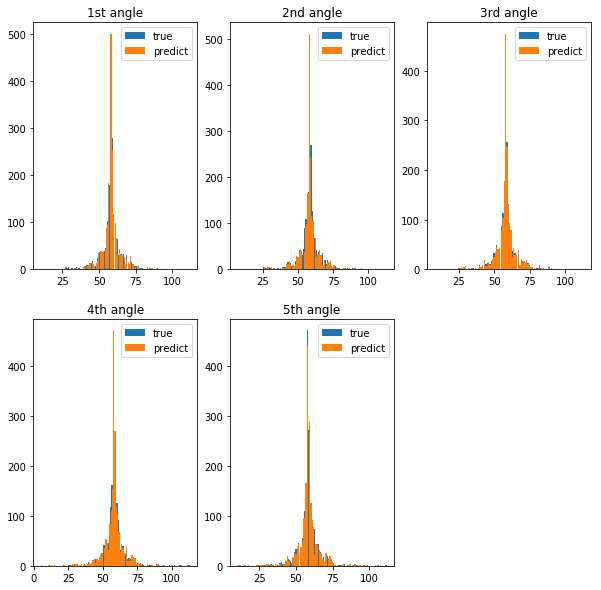

In [21]:
# convert y_val to ID
y_val_id_list = [np.argmax(y_val[j], axis=1) for j in range(NUM_PRED)]
y_hat_id_list = [np.argmax(y_hat[j], axis=1) for j in range(NUM_PRED)]

# Plot angel ID histogram for each prediciton in the sequence
plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.hist(y_val_id_list[0], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[0], bins=NUM_CLASSES, label="predict")
plt.title("1st angle")
plt.legend(loc='upper right')

plt.subplot(232)
plt.hist(y_val_id_list[1], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[1], bins=NUM_CLASSES, label="predict")
plt.title("2nd angle")
plt.legend(loc='upper right')

plt.subplot(233)
plt.hist(y_val_id_list[2], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[2], bins=NUM_CLASSES, label="predict")
plt.title("3rd angle")
plt.legend(loc='upper right')

plt.subplot(234)
plt.hist(y_val_id_list[3], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[3], bins=NUM_CLASSES, label="predict")
plt.title("4th angle")
plt.legend(loc='upper right')

plt.subplot(235)
plt.hist(y_val_id_list[4], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[4], bins=NUM_CLASSES, label="predict")
plt.title("5th angle")
plt.legend(loc='upper right')

# plt.savefig("./s1p10_data/lstm_rev_predicted_angles_distribution.png")
plt.show()


## Confusion matrix

In [22]:
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics

In [23]:
# Convert 1st prediction into class ID
y_val_1 = np.argmax(y_val[0], axis=1)
y_hat_1 = np.argmax(y_hat[0], axis=1)

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        norm_factor = cm.sum(axis=1)[:, np.newaxis]
        norm_factor[norm_factor == 0] = 1
        cm = cm.astype('float') / norm_factor
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(50,50))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


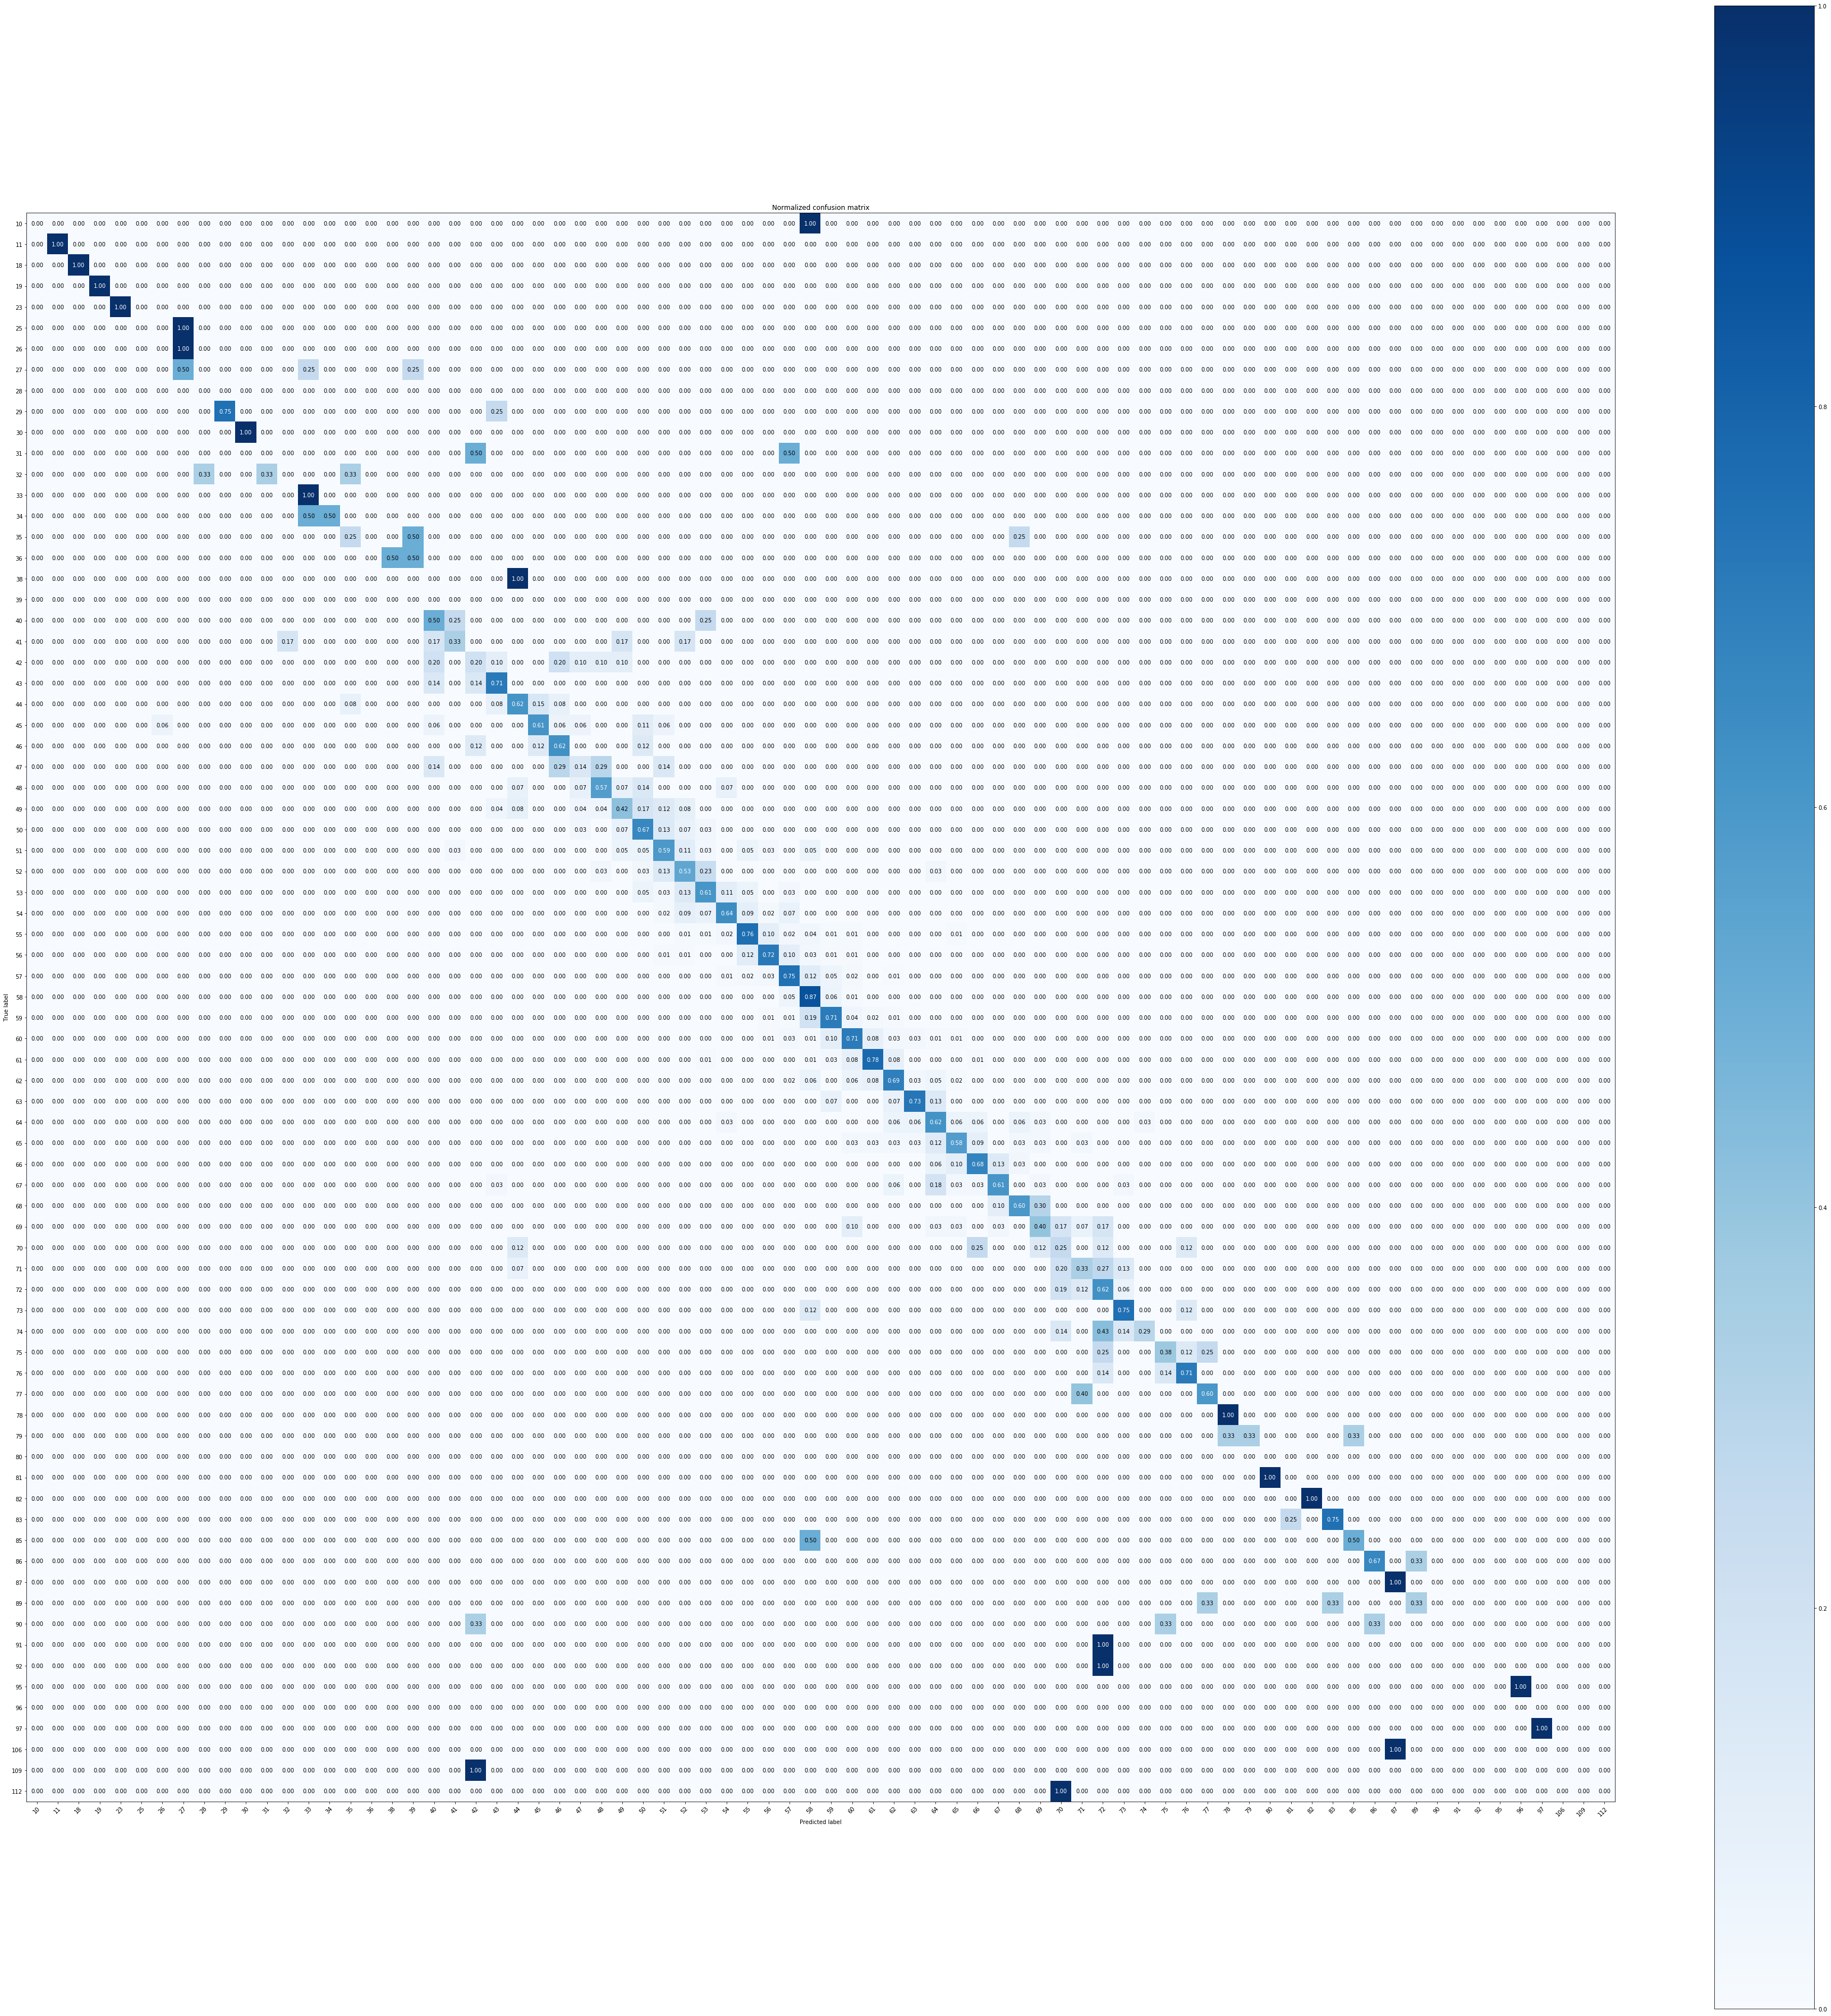

In [26]:
class_names = np.array([str(i) for i in range(114)])
plot_confusion_matrix(y_val_1, y_hat_1, class_names, normalize=True)
plt.savefig("./s1p10_data/lstm_rev_norm_confusion_matrix_2.png")

# Save weights

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(log_dir + "/no_cut_s1p10_model_%s.json" % time_str, "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(log_dir + "/no_cut_s1p10_model_%s.h5" % time_str)
print("Saved model to disk")

In [ ]:
time_str

In [ ]:
# #TODO: save X_train, y_train
# np.save('./s1p10_data/no_cut_CH2_training_X.npy', X_train)
# np.save('./s1p10_data/no_cut_CH2_training_y.npy', y_train)

# np.save('./s1p10_data/no_cut_CH2_validation_X.npy', X_val)
# np.save('./s1p10_data/no_cut_CH2_validation_y.npy', y_val)